In [42]:
import numpy as np
import pandas as pd
import importlib
import simulate_data
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from econml.grf import CausalForest
from econml.metalearners import SLearner, TLearner

importlib.reload(simulate_data)

<module 'simulate_data' from 'C:\\Users\\huber\\OneDrive\\Dokumenty\\Delft\\RP\\code\\research-project\\simulate_data.py'>

In [2]:
data = pd.read_csv("bsc_project_set.csv", index_col=0)
print(data.shape)
data

(3941, 27)


,id,mort_28,age,sex,weight,height,pf_ratio,po2,pco2,ph,...,fio2,hco3,heart_rate,minute_volume,peep,plateau_pressure,respiratory_rate,syst_blood_pressure,diastolic_blood_pressure,peep_regime
0,32128372,False,75,F,93.0,168.0,241.944444,130.666667,28.111111,7.245556,...,50.000000,12.000000,115.408163,8.241111,8.777778,24.333333,18.943662,100.600000,68.200000,low
1,34100191,False,47,M,127.0,183.0,166.356061,113.076923,34.461538,7.196923,...,68.500000,12.750000,115.407407,16.628571,7.375000,17.500000,19.857143,99.000000,68.000000,low
2,38292466,False,85,M,77.5,170.0,224.000000,112.000000,38.000000,7.440000,...,51.818182,23.000000,70.041667,9.433333,5.000000,22.333333,15.833333,102.000000,46.333333,low
3,32743332,False,85,M,90.7,170.0,205.714286,72.000000,38.000000,7.500000,...,36.875000,27.000000,70.480000,7.478571,5.000000,24.000000,18.200000,108.083333,46.208333,low
4,35009126,True,64,M,70.0,183.0,173.777778,94.666667,38.666667,7.400000,...,52.500000,21.666667,73.955556,7.050000,5.428571,14.328571,15.016667,103.415094,57.377358,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3936,32959861,True,78,F,57.0,160.0,157.178571,136.833333,38.083333,7.370833,...,65.454545,22.000000,95.785714,8.511111,6.800000,22.000000,16.677419,NaN,NaN,low
3937,32761676,False,75,M,101.0,178.0,179.909091,91.714286,39.000000,7.310000,...,52.142857,17.600000,60.394737,7.250000,5.000000,15.400000,16.795455,NaN,NaN,low
3938,34058245,True,67,F,100.0,165.0,158.331733,104.250000,43.250000,7.292500,...,77.142857,18.800000,122.041667,8.813333,16.700000,30.333333,25.290323,101.789474,59.631579,high
3939,34670930,False,68,M,94.7,163.0,192.500000,90.600000,40.400000,7.414000,...,60.000000,23.500000,65.807692,8.816667,9.166667,21.285714,21.531250,158.000000,83.500000,low


In [3]:
xs = data.copy()

y = xs["mort_28"]
w = xs["peep_regime"]

# w.loc[w == "low"] = 0
# w.loc[w["peep_regime"] == "high", "peep_regime"] = 1
# w = w.replace(to_replace=["low", "high"], value=[0, 1])
w = pd.Series(map(lambda x: 0 if x == "low" else 1, w))

xs = xs.drop(columns=["id", "mort_28", "peep", "peep_regime"])

xs.loc[xs["sex"] == "M", "sex"] = 0
xs.loc[xs["sex"] == "F", "sex"] = 1
# xs["sex"] = xs["sex"].replace({"M": 0, "F": 1})

# data2 = data["sex"].replace({"M": 0, "F": 1})
# data2

xs

,age,sex,weight,height,pf_ratio,po2,pco2,ph,driving_pressure,lung_compliance,...,platelets,urea,fio2,hco3,heart_rate,minute_volume,plateau_pressure,respiratory_rate,syst_blood_pressure,diastolic_blood_pressure
0,75,1,93.0,168.0,241.944444,130.666667,28.111111,7.245556,11.000000,31.227273,...,83.000000,3.71280,50.000000,12.000000,115.408163,8.241111,24.333333,18.943662,100.600000,68.200000
1,47,0,127.0,183.0,166.356061,113.076923,34.461538,7.196923,8.350000,79.780702,...,19.600000,32.21925,68.500000,12.750000,115.407407,16.628571,17.500000,19.857143,99.000000,68.000000
2,85,0,77.5,170.0,224.000000,112.000000,38.000000,7.440000,17.250000,33.338235,...,124.500000,16.42200,51.818182,23.000000,70.041667,9.433333,22.333333,15.833333,102.000000,46.333333
3,85,0,90.7,170.0,205.714286,72.000000,38.000000,7.500000,17.000000,26.882353,...,200.000000,24.63300,36.875000,27.000000,70.480000,7.478571,24.000000,18.200000,108.083333,46.208333
4,64,0,70.0,183.0,173.777778,94.666667,38.666667,7.400000,8.585714,52.821226,...,513.666667,5.11700,52.500000,21.666667,73.955556,7.050000,14.328571,15.016667,103.415094,57.377358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3936,78,1,57.0,160.0,157.178571,136.833333,38.083333,7.370833,16.400000,26.829268,...,209.666667,14.63700,65.454545,22.000000,95.785714,8.511111,22.000000,16.677419,NaN,NaN
3937,75,0,101.0,178.0,179.909091,91.714286,39.000000,7.310000,10.400000,42.412137,...,78.200000,28.70280,52.142857,17.600000,60.394737,7.250000,15.400000,16.795455,NaN,NaN
3938,67,1,100.0,165.0,158.331733,104.250000,43.250000,7.292500,13.200000,25.796667,...,309.400000,15.06540,77.142857,18.800000,122.041667,8.813333,30.333333,25.290323,101.789474,59.631579
3939,68,0,94.7,163.0,192.500000,90.600000,40.400000,7.414000,12.500000,33.805421,...,151.200000,6.69375,60.000000,23.500000,65.807692,8.816667,21.285714,21.531250,158.000000,83.500000


In [4]:
y

0       False
1       False
2       False
3       False
4        True
        ...  
3936     True
3937    False
3938     True
3939    False
3940     True
Name: mort_28, Length: 3941, dtype: bool

In [5]:
w

0       0
1       0
2       0
3       0
4       0
       ..
3936    0
3937    0
3938    1
3939    0
3940    0
Length: 3941, dtype: int64

# Example Simulation
Balanced case with simple CATE

In [37]:
e = lambda x: 0.5
d = 5
weights = np.random.uniform(-5, 5, d)
mu_0 = lambda x: np.dot(x, weights) #+ 5 * (1 if x[0] > 0.5 else 0)
mu_1 = lambda x: mu_0(x) + 20 #+ 8 * (1 if x[1] > 0.5 else 0)
n = 5000

sim = pd.DataFrame(simulate_data.get_training_set(d, mu_0, mu_1, e, n))
# sim_x = list(map(lambda a: a["X"], sim))
# sim_w = list(map(lambda a: a["W"], sim))
sim_y = sim["Y"]
sim_w = sim["W"]
sim_x = pd.DataFrame(sim["X"].tolist(), index = sim.index)
sim_x.columns = sim_x.columns.astype(str)
sim_x_s = sim_x.assign(W=pd.Series(sim["W"]).values)

sim_x_t_0 = pd.DataFrame(sim.query("W==0")["X"].tolist())
sim_x_t_0.columns = sim_x_t_0.columns.astype(str)
sim_x_t_1 = pd.DataFrame(sim.query("W==1")["X"].tolist())
sim_x_t_1.columns = sim_x_t_1.columns.astype(str)
# sim_x_s.columns = sim_x_s.columns.astype(str)
# sim_x_s = sim.apply(lambda x: np.append(x["X"], x["W"]), axis=1).to_list()
# sim_x_s
print(sim_y[0])
# sim_x_s
# sim_x_s.values.tolist()
sim_x_t_0
# sim_x_t_1

-3.519063896657287


,0,1,2,3,4
0,0.244733,0.589970,-0.065744,-1.193720,1.708224
1,-1.210075,0.020499,-1.560494,0.023123,-0.107883
2,-0.451281,0.789094,0.713983,-0.709256,0.489267
3,0.973322,-0.322073,1.961650,-0.307863,-0.464946
4,-0.464968,0.331727,0.078946,-0.800991,1.084369
...,...,...,...,...,...
2542,-0.135795,0.448661,0.329991,1.182578,-0.421509
2543,0.851469,0.394094,-2.433262,-1.690468,0.456063
2544,-1.803237,0.109214,-1.242796,1.367979,-0.132480
2545,-0.806549,-1.141055,-0.474083,0.556109,1.648112


## S-learner

In [38]:
# regr = RandomForestRegressor(n_estimators=30, min_samples_split=10)
regr = RandomForestRegressor()
# regr = LinearRegression()
# sim_x_s = list(map(lambda a: np.append(a[0], a[1]), zip(sim_x, sim_w)))
regr.fit(sim_x_s, sim_y)

y_fitted = regr.predict(sim_x_s)
print(y_fitted[0])
mean_squared_error(sim_y, y_fitted)

-3.3042273797105137


0.23061822947079771

In [39]:
sim_test = pd.DataFrame(simulate_data.get_test_set(d, mu_0, mu_1, e, 1000))

sim_test_x = pd.DataFrame(sim_test["X"].tolist(), index=sim_test.index)
sim_test_x.columns = sim_test_x.columns.astype(str)

# test_sim_x_0 = sim_test.apply(lambda x: np.append(x["X"], 0), axis=1).to_list()
test_sim_x_0 = sim_test_x.assign(**{"W": 0})
# test_sim_x_1 = sim_test.apply(lambda x: np.append(x["X"], 1), axis=1).to_list()
test_sim_x_1 = sim_test_x.assign(**{"W": 1})
test_sim_y = np.append(sim_test["Y0"], sim_test["Y1"])
# test_sim_x_0

y_test_pred = regr.predict(pd.concat([test_sim_x_0, test_sim_x_1]))
mean_squared_error(test_sim_y, y_test_pred)

# test_sim_x_0

# sim_test_x
# test_sim_x_0
# sim_test

1.5177300971948757

In [20]:
def sensitivity(data, y, t):
        # line coeficient for the one variable linear regression
        return (np.sum((data[t] - data[t].mean())*(data[y] - data[y].mean())) /
                np.sum((data[t] - data[t].mean())**2))

def cumulative_gain(dataset, prediction, y, t, min_periods=30, steps=100):
    size = dataset.shape[0]
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)
    n_rows = list(range(min_periods, size, size // steps)) + [size]

    ## add (rows/size) as a normalizer.
    return np.array([sensitivity(ordered_df.head(rows), y, t) * (rows/size) for rows in n_rows])

In [21]:
s_learner_cate_train = (regr.predict(sim_x.assign(**{"W": 1})) -
                        regr.predict(sim_x.assign(**{"W": 0})))

s_learner_cate_test = sim_test_x.assign(
    cate=(regr.predict(sim_test_x.assign(**{"W": 1})) - # predict under treatment
          regr.predict(sim_test_x.assign(**{"W": 0}))) # predict under control
)

In [22]:
s_learner_cate_test

,0,1,2,3,4,cate
0,0.335375,-0.444512,0.574506,2.387989,0.547472,19.527294
1,0.001389,-0.720202,-0.301605,-0.440492,-0.515836,20.461822
2,-0.941319,0.522885,-0.584281,0.592234,0.303215,19.576277
3,-1.127343,-0.062090,-0.342199,-0.182807,-0.551073,20.515316
4,-0.026548,0.130662,-1.486043,-0.070988,0.185261,19.691943
...,...,...,...,...,...,...
995,0.224643,-1.197938,-0.283342,1.964455,-0.119721,18.886241
996,-0.028380,-0.894758,1.414400,-0.290796,-0.610972,20.314730
997,-0.052130,0.960327,-0.294072,1.014329,-1.294869,21.131894
998,-0.244870,0.158720,-1.103358,0.675544,-0.328981,20.257205


In [62]:
# gain_curve_test = cumulative_gain(s_learner_cate_test.assign(**{"W": sim_test["W"], "Y": sim_test["Y"]}), "cate", y="Y", t="W")
# gain_curve_train = cumulative_gain(sim_x.assign(cate=s_learner_cate_train, W=sim["W"], Y=sim["Y"]), "cate", y="Y", t="W")
# plt.plot(gain_curve_test, color="C0", label="Test")
# plt.plot(gain_curve_train, color="C1", label="Train")
# # plt.plot([0, 100], [0, elast(test, "converted", "em1")], linestyle="--", color="black", label="Baseline")
# plt.plot([0, 100], [0, sensitivity(s_learner_cate_test.assign(**{"W": sim_test["W"], "Y": sim_test["Y"]}), "Y", "W")], linestyle="--", color="black", label="Baseline")
# plt.legend()
# plt.title("S-Learner");

In [23]:
mean_squared_error(s_learner_cate_test.cate, sim_test.Y1 - sim_test.Y0)
# s_learner_cate_test
# sim_test.Y1 - sim_test.Y0

0.7284567874224736

# T-learner

In [24]:
regr0 = RandomForestRegressor()
regr1 = RandomForestRegressor()

regr0.fit(sim_x_t_0, sim.query("W==0")["Y"])
regr1.fit(sim_x_t_1, sim.query("W==1")["Y"])

t_learner_cate_train = regr1.predict(sim_x) - regr0.predict(sim_x)
t_learner_cate_test = sim_test_x.assign(cate=regr1.predict(sim_test_x) - regr0.predict(sim_test_x))

In [25]:
t_learner_cate_test

,0,1,2,3,4,cate
0,0.335375,-0.444512,0.574506,2.387989,0.547472,19.755996
1,0.001389,-0.720202,-0.301605,-0.440492,-0.515836,20.400462
2,-0.941319,0.522885,-0.584281,0.592234,0.303215,19.577074
3,-1.127343,-0.062090,-0.342199,-0.182807,-0.551073,20.107031
4,-0.026548,0.130662,-1.486043,-0.070988,0.185261,19.387881
...,...,...,...,...,...,...
995,0.224643,-1.197938,-0.283342,1.964455,-0.119721,18.918116
996,-0.028380,-0.894758,1.414400,-0.290796,-0.610972,20.292230
997,-0.052130,0.960327,-0.294072,1.014329,-1.294869,21.605646
998,-0.244870,0.158720,-1.103358,0.675544,-0.328981,20.993597


In [26]:
mean_squared_error(t_learner_cate_test.cate, sim_test.Y1 - sim_test.Y0)

0.7465798618716428

In [27]:
cau_forest = CausalForest()
cau_forest.fit(sim_x, sim_w, sim_y)

ret = cau_forest.predict(sim_test_x)
ret

array([[19.75407549],
       [20.07363709],
       [20.1478182 ],
       [19.80803575],
       [20.29007027],
       [20.38179187],
       [20.93677179],
       [19.57130031],
       [20.29984135],
       [20.42102563],
       [19.62623155],
       [20.58280959],
       [20.32744207],
       [19.77221668],
       [19.72690705],
       [20.09467163],
       [19.89809642],
       [19.84480615],
       [19.62826034],
       [19.69482223],
       [20.44636911],
       [20.35191623],
       [20.31028223],
       [19.60198576],
       [19.90523899],
       [20.61349649],
       [20.30930695],
       [19.86998912],
       [20.30971882],
       [19.33075991],
       [20.2534088 ],
       [19.32366011],
       [19.94891434],
       [19.84163198],
       [20.33058864],
       [20.26527305],
       [20.08926901],
       [20.05865215],
       [19.80770221],
       [19.83621335],
       [19.4858769 ],
       [20.17712514],
       [20.01784359],
       [19.92445009],
       [20.18591218],
       [20

In [28]:
mean_squared_error(ret, sim_test.Y1 - sim_test.Y0)

0.22371552135330805

[6.776936786945289, 4.5058507287001905, 3.2284678427135804, 3.150693692962789, 1.9073466548718871, 1.6745326559407718, 1.2564625930134061]
[3.6805425131156997, 2.964818076374953, 2.3593960422291316, 1.566630089423243, 1.3105584882493257, 1.2599881725362152, 0.8578066241548774]
[2.0809735209279965, 1.5477972152796302, 0.5515528687537571, 0.4374154391216555, 0.26904050284841163, 0.3082204513934361, 0.2700739772877669]
[7.318555290859253, 4.435598779073409, 3.875163979487291, 3.1462279674952436, 1.7571863862168737, 1.6286164046013059, 1.2213473380534672]
[7.2734604505122356, 4.201534200623367, 3.3138795471951834, 2.804926686314252, 1.7049522255980503, 1.5451163714919025, 1.1906105316407498]


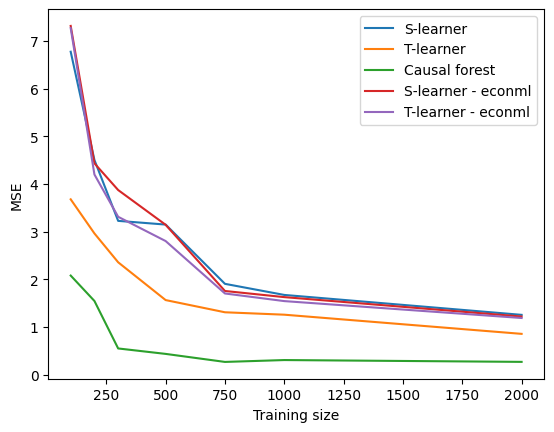

In [44]:
training_sizes = [100, 200, 300, 500, 750, 1000, 2000]
mse_s = []
mse_t = []
mse_forest = []
mse_econml_s = []
mse_econml_t = []

for size in training_sizes:
    # S-learner
    regr = RandomForestRegressor()
    regr.fit(sim_x_s.head(size), sim_y.head(size))

    s_learner_cate_test = sim_test_x.assign(
        cate=(regr.predict(sim_test_x.assign(**{"W": 1})) - # predict under treatment
            regr.predict(sim_test_x.assign(**{"W": 0}))) # predict under control
    )
    mse_s.append(mean_squared_error(s_learner_cate_test.cate, sim_test.Y1 - sim_test.Y0))

    # T-learner
    regr0 = RandomForestRegressor()
    regr1 = RandomForestRegressor()
    regr0.fit(sim_x_t_0.head(size), sim.query("W==0")["Y"].head(size))
    regr1.fit(sim_x_t_1.head(size), sim.query("W==1")["Y"].head(size))

    t_learner_cate_test = sim_test_x.assign(cate=regr1.predict(sim_test_x) - regr0.predict(sim_test_x))
    mse_t.append(mean_squared_error(t_learner_cate_test.cate, sim_test.Y1 - sim_test.Y0))

    # Causal forest
    cau_forest = CausalForest()
    cau_forest.fit(sim_x.head(size), sim_w.head(size), sim_y.head(size))

    causal_forest_cate = cau_forest.predict(sim_test_x)
    mse_forest.append(mean_squared_error(causal_forest_cate, sim_test.Y1 - sim_test.Y0))

    econml_s = SLearner(overall_model=RandomForestRegressor())
    econml_s.fit(sim_y.head(size), sim_w.head(size), X=sim_x.head(size))
    econml_s_cate = econml_s.effect(sim_test_x)
    mse_econml_s.append(mean_squared_error(econml_s_cate, sim_test.Y1 - sim_test.Y0))

    econml_t = TLearner(models=RandomForestRegressor())
    econml_t.fit(sim_y.head(size), sim_w.head(size), X=sim_x.head(size))
    econml_t_cate = econml_t.effect(sim_test_x)
    mse_econml_t.append(mean_squared_error(econml_t_cate, sim_test.Y1 - sim_test.Y0))



print(mse_s)
print(mse_t)
print(mse_forest)
print(mse_econml_s)
print(mse_econml_t)

plt.plot(training_sizes, mse_s, label="S-learner")
plt.plot(training_sizes, mse_t, label="T-learner")
plt.plot(training_sizes, mse_forest, label="Causal forest")
plt.plot(training_sizes, mse_econml_s, label="S-learner - econml")
plt.plot(training_sizes, mse_econml_t, label="T-learner - econml")
plt.ylabel("MSE")
plt.xlabel("Training size")
plt.legend()
plt.show()